**If you like my notebook, please upvote my work!**

**If you use parts of this notebook in your scripts/notebooks, giving some kind of credit for instance link back to this notebook would be very much appreciated. Thanks in advance! :)**

**Thankyou! :) Hope you like my work!**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**We will be using minimax and only minimax rather than deep reinforcement learning techniques to achieve this score as it is one of the most enduring methods in reinforcement learning as an AI in two player games.**

# What is minimax?

Minimax is a AI method of deciding the best move to make in 2 player games that analyses all the various possibilites at hand by giving each possible permutation a score of how favourable it is to the player and then attempts to maximise the score assuming that the other player plays optimally. Briefly speaking, a minmax with 2 step lookahead calculates all the possible board configurations that can be obtained after it make one moves and then the opponent also makes one move most favourable to them. Then it checks which configuration out of all those configurations is best suited to him. We can easily see that this will form a tree structure because if the board is empty, our agent can make 8 possible moves and then for each of its 8 moves the opponent can also make a move in either of the 8 columns thus the agent has to analyse a total of 64 boards.

You can read more about the algorithm [here](https://www.geeksforgeeks.org/minimax-algorithm-in-game-theory-set-1-introduction/) on geeks for geeks.

I would also recommend reading [this](https://www.kaggle.com/alexisbcook/one-step-lookahead) notebook from the reinforcement learning course which will help you get a better understanding as most of the functions implemented here have a similar structure.

# Defining the Heuristic.

Okay so the most important thing for the algorithm to work properly and effeciently is defining the heuristic properly and then we can define the rest of the functions to use this heuristic in order to achieve the task of playing the game.

So the most important part is to decide how we want to motivate the AI. For that these are the points we need to keep in mind:
1. Getting 2 in a row is difficult than getting 1 in a row. Getting 3 in a row is difficult than getting 2 in a row and so on. Thus we want to reward the AI when it gets higher number of pieces in a row than when it gets lower number of pieces in a row.

2. Now the question is how much more score we want to give? So for that we imagine a grid randomly filled with 1s and 0s. In such a grid there would me exponentially more number of x pieces of 1s in a row than x-1 pieces of ones in a row thus we want to give exponentially greater score when AI makes higher and higher number of pieces in a row.

3. VVIP(Very Very Important Point):Now lets talk about the enemy. Lets say we are the color red and before dropping our piece on the board we have max 2 in a row and the enemy has max 3 in a row(Taking the objective of the game to be to connect 4 in a row). If we can drop the piece in such a way that we can only either extend our 3 in a row or stop the enemy from making 4 in a row, it is more important to stop the enemy. Thus when we run the hueristic after dropping the piece the heuristic shoud penalise more if both the players have 3 in a row since we have already dropped our piece and now it will be the enemy's turn to play.

Keeping these points in mind we can define the heuristic as follows:

In [ ]:
def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num  = count_windows (grid,i+1,mark,config)
        score += (4**(i+1))*num
    for i in range(config.inarow):
        num_opp = count_windows (grid,i+1,mark%2+1,config)
        score-= (2**((2*i)+3))*num_opp
    return score

We will take each window of 4 on the board and use it to evaluate a score.

# Defining the rest of the functions 

Nothing much to explain here. Most of the functions are the same as compared to the tutorial notebook.

In [ ]:
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

# Implementing minimax

Here we have used 2 functions score_move_a and score_move_b that are calling each other recursively.

In [ ]:
def score_move_a(grid, col, mark, config,n_steps=1):
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    if len(valid_moves)==0 or n_steps ==0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else :
        scores = [score_move_b(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = min(scores)
    return score

def score_move_b(grid, col, mark, config,n_steps):
    next_grid = drop_piece(grid,col,(mark%2)+1,config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    if len(valid_moves)==0 or n_steps ==0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else :
        scores = [score_move_a(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = max(scores)
    return score

# Defining the agent.

Here we have implemented a 1 step look-ahead agent. 

In [ ]:
def agent(obs, config):
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid, col, obs.mark, config,1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

## Testing the agent against negamax

In [ ]:
from kaggle_environments import make, evaluate

In [ ]:
env = make("connectx", debug=True)
env.run([agent,"negamax"])
env.render(mode="ipython")

## Getting win percentage

Since one iteration is not enough to conclude which agent is better we run 100 iterations.

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    config = {'rows': 10, 'columns': 7, 'inarow': 4}
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [ ]:
get_win_percentages(agent1=agent, agent2="negamax",n_rounds = 100)

Now the algorithm works good and does get a good score but the question is how can we do better? 

So the thing is There are two main problems with the algorithm.

1. The first one is fairly obvious that the this version of minimax is not efficient and could do better with optimisations like alpha-beta pruning.

2. The second problem is a bit more subtle and complex. If you carefully understand what minimax is doing, it computes the score for each permutation possible but the agent will often come across a case when both players can win if they make a move and it is your agents turn as shown below. 

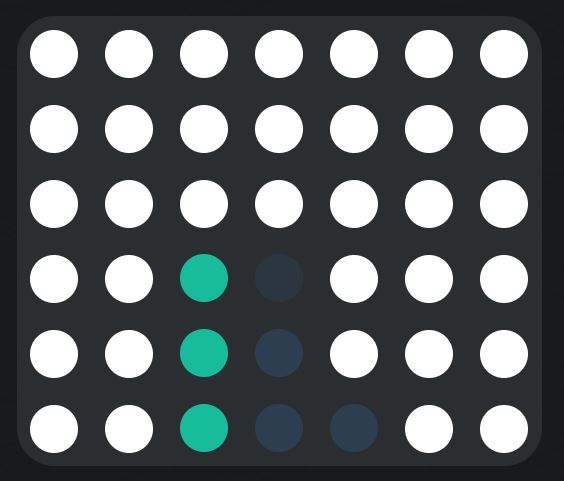

If you are playing with color green you can win this turn by playing in column 3(1 based indexing) but the agent will not play in this column rather in column 4. This is because when it computes the score, he sees that after he makes a 4 in a row the opponent also makes a 4 in a row and since it adds a higher penalty, the agent tries to stop the other one raher than making his own because the agent does not understand the concept that the game ends as soon as he makes a 4 in a row. First we will try to address the first problem by making minor tweaks to the functions.

# Improved agent

First we shall tweak the heuristic function to return a score of infinity whenever we get a 4 in a row and a score of -infinity if the opponent gets a 4 in a row.

## Tweaking the hueristic

In [ ]:
def get_heuristic(grid, mark, config):
    score = 0
    for i in range(config.inarow):
        num  = count_windows (grid,i+1,mark,config)
        if (i==(config.inarow-1) and num >= 1):
            return float("inf")
        score += (4**(i+1))*num
    for i in range(config.inarow):
        num_opp = count_windows (grid,i+1,mark%2+1,config)
        if (i==(config.inarow-1) and num_opp >= 1):
            return float ("-inf")
        score-= (2**((2*i)+3))*num_opp
    return score

## Tweaking the minimax functions

In [ ]:
def score_move_a(grid, col, mark, config,n_steps=1):
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    score = get_heuristic(next_grid, mark, config)
    #Since we have just dropped our piece there is only the possibility of us getting 4 in a row and not the opponent.
    #Thus score can only be +infinity.
    if len(valid_moves)==0 or n_steps ==0 or score == float("inf"):
        return score
    else :
        scores = [score_move_b(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = min(scores)
    return score

def score_move_b(grid, col, mark, config,n_steps):
    next_grid = drop_piece(grid,col,(mark%2)+1,config)
    valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
    score = get_heuristic(next_grid, mark, config)
    #The converse is true here.
    #Since we have just dropped opponent piece there is only the possibility of opponent getting 4 in a row and not us.
    #Thus score can only be -infinity.
    if len(valid_moves)==0 or n_steps ==0 or score == float ("-inf"):
        return score
    else :
        scores = [score_move_a(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
        score = max(scores)
    return score

## Defining the agent with new functions

In [ ]:
def agent(obs, config):
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid, col, obs.mark, config,1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

By doing these few tweaks the function will return the score of infinity as soon as it selects a row that makes a four in a row thus making the score higher than could be obtained any other way.

This also ensures that if by us making a move enables the opponent to make a four in a row, a score of -infinity is returned and that path in the minimax tree is thrown out and the agent gives any other path a priority if it returns a non -infinity score without condsidering how low the score is.

## Testing against negamax

In [ ]:
env = make("connectx", debug=True)
env.run([agent,"negamax"])
env.render(mode="ipython")

## Obtaining the win percentage

In [ ]:
get_win_percentages(agent1=agent, agent2="negamax",n_rounds = 100)

## Understanding the complexity for a one step lookahead:

For one step lookahead the following steps are to be performed:

P.S: Here we have considered a board size on n*n and m pieces to connect

1. The program drops a piece in each of the n columns which takes O(n^2) and generates n configurations

2. For each of the n columns, it agains drops opponent piece in each possible column O(n^3) and genrates n^2 configurations

3. For each of these n^2 cofigurations, a heuristic function is called upon. This heuristic function calls count_windows for each value less than config.inarow resulting in (n^2)*m configuraions

4. The count_windows isolates all possible windows of size config.inarow in the grid resulting in [(n^2) * m]*[n * (n-m+1) horizontal windows + n * (n-m+1) vertical windows + (n-m+1)^2 diagonal windows along both the diagonals] which we can take as (n^4)*m for simplicity

5. Now for each of these windows a check_window is called once resulting in the total complexity to be [(n^4)*m] * m since the complexity of check window itself is m 

6. The final complexity is of the order (n^4)*(m^2)

Now the question is how can we make this algorithm more effecient? This has been covered in great depth in my other notebook [here](https://www.kaggle.com/sidagar/making-minimax-20x-faster). 

**Please upvote if you liked my work. I have tried to make this as intuitive as possible. Any suggestions are welcome. Thank You!!**